In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def cleanup_names(df):
    def convert_value_var(name):
        return name.replace('_accuracy', '').replace('quantized_', '').capitalize()

    value_vars = ['original_accuracy', 'quantized_accuracy_nearest', 'quantized_accuracy_stochastic', 'quantized_accuracy_adaround']
    id_vars = [c for c in df.columns if c not in value_vars and c != 'iteration']

    df = df.rename(columns={c: convert_value_var(c) for c in value_vars})
    df = df.rename(columns={c: c.replace("_", " ").capitalize() for c in id_vars})

    return df, [convert_value_var(c) for c in value_vars]

def merge_key_columns(df, value_vars):
    id_vars = [c for c in df.columns if c not in value_vars and c != 'iteration']
    key = ', '.join(id_vars)
    df[key] = df[id_vars].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)

    return df, id_vars, key

def display_plot(filename):
    df = pd.read_pickle('../results/' + filename)
    df, value_vars = cleanup_names(df)
    df, id_vars, key = merge_key_columns(df, value_vars)
    df_original = df.copy()

    df = df.melt(id_vars=['iteration', key], value_vars=value_vars, var_name='Quantization method', value_name='Accuracy')
    
    df["col"] = 1
    adaround_copy = df[df["Quantization method"] == "Adaround"].copy()
    adaround_copy["col"] = 2
    df = pd.concat([df, adaround_copy])

    g = sns.catplot(
        data=df[df["Quantization method"] != "Original"], 
        x=key, y='Accuracy', hue='Quantization method',
        col='col',
        kind='box', legend=False, sharey=False
    )
    for ax, title in zip(g.axes.flat, ["", "Zoomed in"]):
        ax.set_title(title)

    original_accuracy = df[df["Quantization method"] == "Original"]["Accuracy"].mean()
    def const_line(*args, **kwargs):
        plt.axhline(y=original_accuracy, color='r', linestyle='--', label='No quantization')
    g.map(const_line)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Quantization method')

    plt.show()

    if len(id_vars) == 2:
        fig, axs = plt.subplots(1, len(value_vars)-1, figsize=(15, 5))
        fig.suptitle('Mean accuracy')
        min = df_original[value_vars[1:]].min().min()
        max = df_original[value_vars[1:]].max().max()

        for i, value_var in enumerate(value_vars[1:]):
            df = df_original.copy()
            df = df.groupby(id_vars).mean().reset_index()
            df = df.pivot(index=id_vars[0], columns=id_vars[1], values=value_var)
            df = df.sort_index(ascending=False)
            g = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[i], cbar=i==len(value_vars)-2, vmin=min, vmax=max)
            axs[i].set_title(value_var)


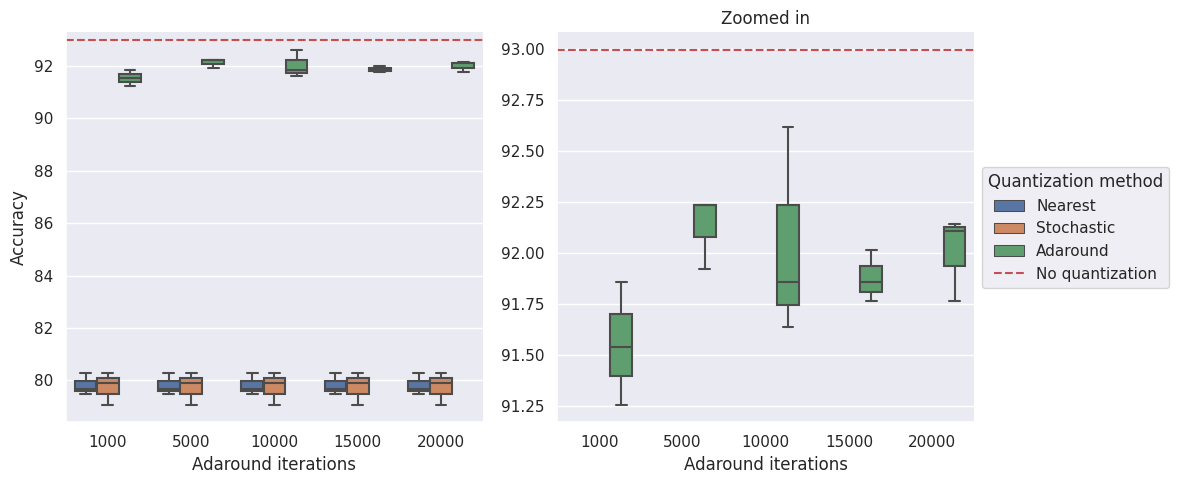

In [94]:
display_plot('ADAROUND_ITERATIONS')

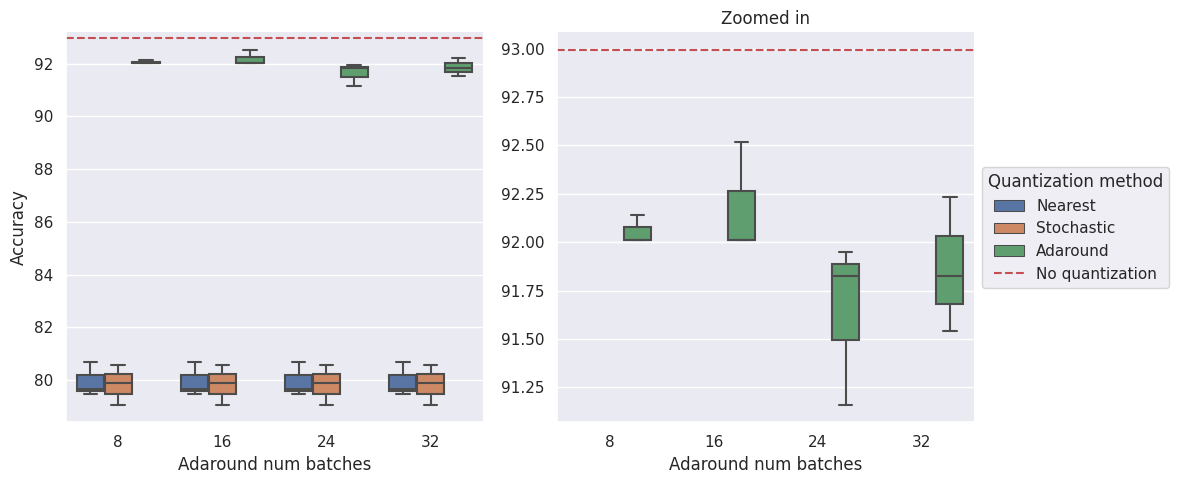

In [95]:
display_plot('ADAROUND_NUM_BATCHES')

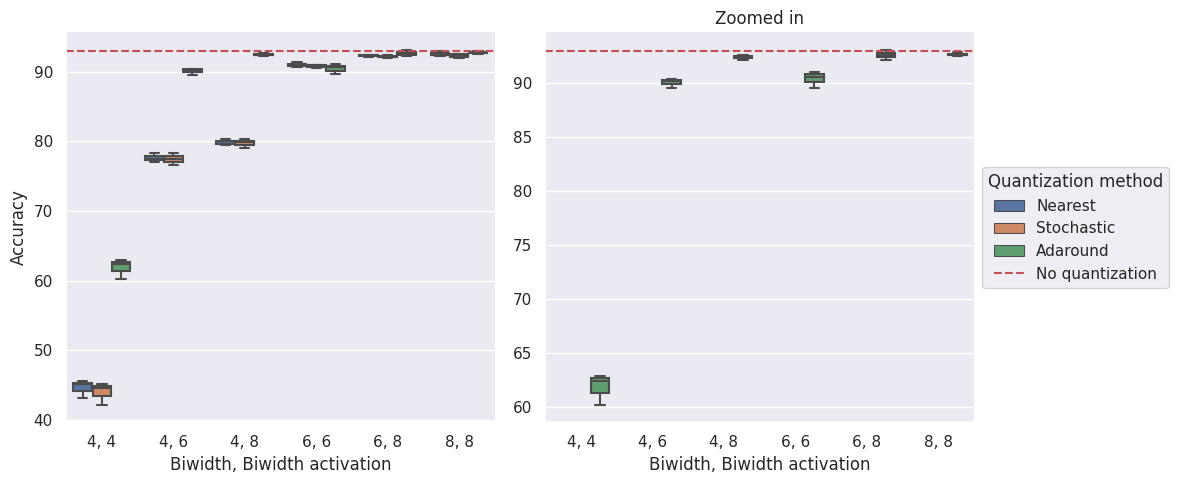

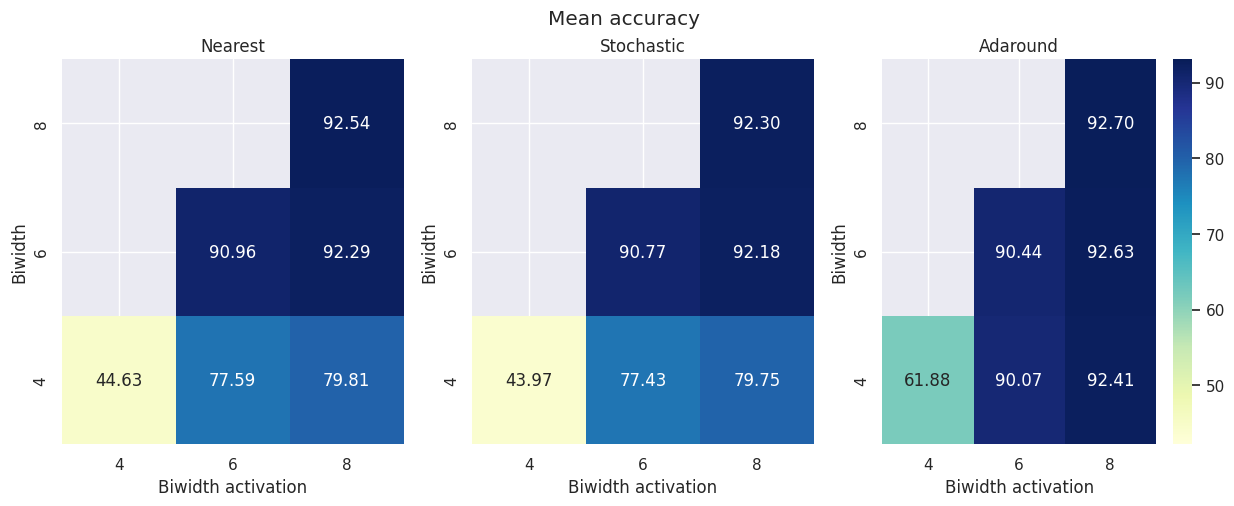

In [96]:
display_plot('BIWIDTH')

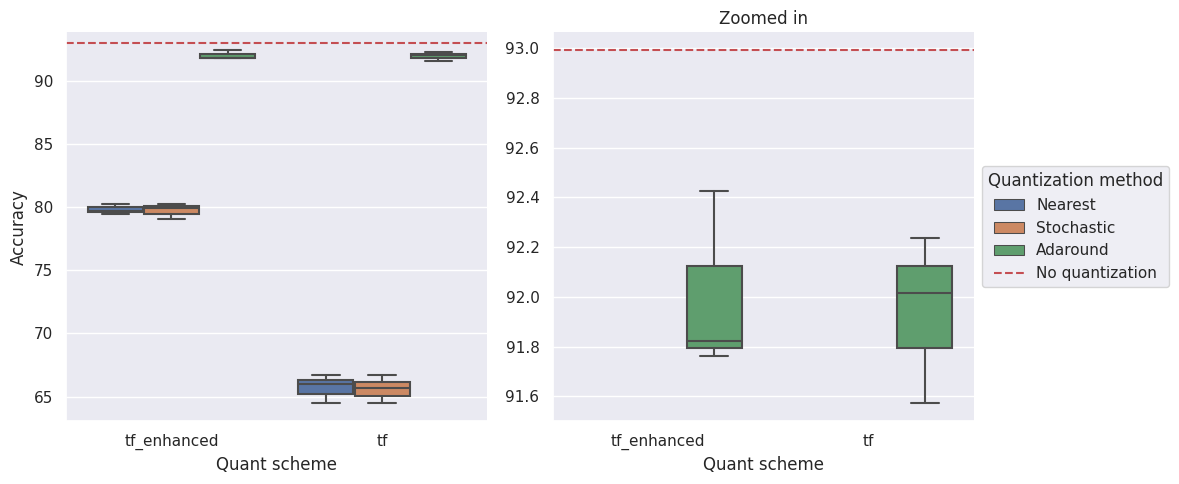

In [97]:
display_plot('QUANT_SCHEME')